In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
import sys
import os
import numpy as np
sns.set_palette("hls", 8)

data_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\data_2021'




In [137]:
data = pd.read_csv(os.path.join(data_path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
data['Churn'] = data['Churn'].apply(lambda x: np.where(x=='Yes',1,0))
data['entry_age'] = 0
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data = data[data.tenure>data.entry_age]
data.head(3)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   

      PaymentMethod MonthlyCharges TotalCharges  Churn  entry_age  
0  Electronic check          29.85        29.85      0          0  
1      Mailed check          56.95      1889.50      0          0  
2      Mailed check          53.85       108.15      1          0  

[3 rows x 22 columns]

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

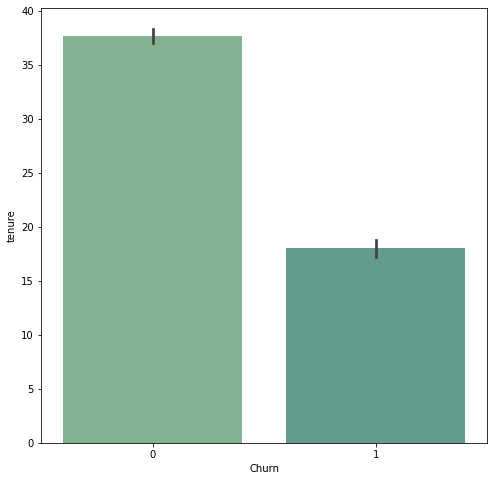

In [23]:
plt.figure(figsize=(8,8))
sns.barplot(data=data, x='Churn', y='tenure')


### K-M Plot

Text(0, 0.5, 'Survival probability')

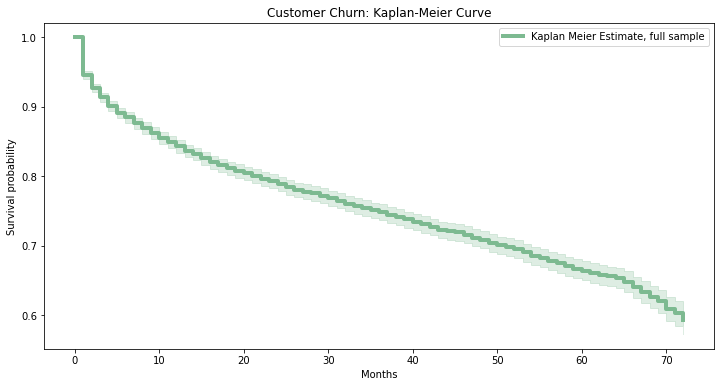

In [25]:
kmf = KaplanMeierFitter()

kmf.fit(data.tenure, 
        data.Churn, 
        entry = data.entry_age,
        label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Customer Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

### K-M Plot for various subsamples

In [26]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'entry_age'],
      dtype='object')

Churn
0    AxesSubplot(0.547727,0.125;0.352273x0.755)
1    AxesSubplot(0.547727,0.125;0.352273x0.755)
Name: tenure, dtype: object

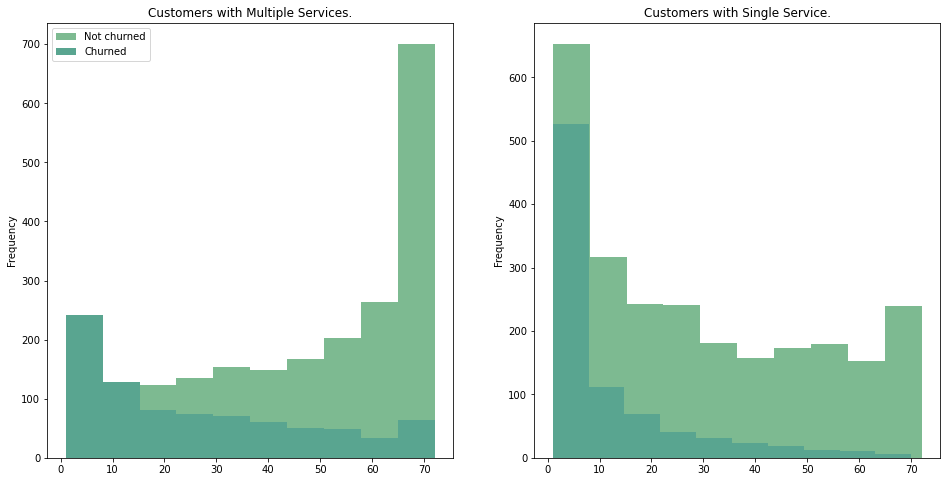

In [27]:
# Let's look at the 'multiple services variable'
df1 = data[data.MultipleLines=='Yes']
df2 = data[data.MultipleLines=='No']
fig, ax = plt.subplots(1,2, figsize=(16,8))
df1.groupby('Churn')['tenure'].plot(kind='hist', ax=ax[0], title='Customers with Multiple Services.')
ax[0].legend(labels=['Not churned', 'Churned'])
df2.groupby('Churn')['tenure'].plot(kind='hist', ax=ax[1], title='Customers with Single Service.')


In [34]:
T = data['tenure']
E = data['Churn']

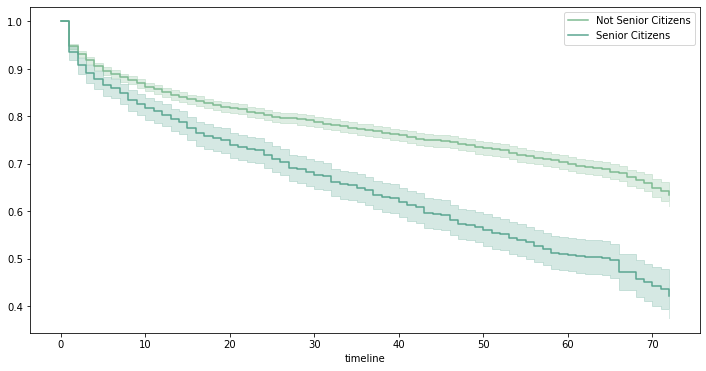

In [41]:
seniorCitizen = (data['SeniorCitizen'] == 1)

kmf.fit(T[~seniorCitizen], E[~seniorCitizen], label = 'Not Senior Citizens')
ax = kmf.plot(figsize=(12, 6))
# kmf.plot_cumulative_density()

kmf.fit(T[seniorCitizen], E[seniorCitizen], label = 'Senior Citizens')
ax = kmf.plot(ax=ax)
# kmf.plot_cumulative_density()
plt.title('Number of Services and Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')


### Log-Rank Test

In [16]:
logrank = logrank_test(data[data.SeniorCitizen==0]['tenure'], 
             data[data.SeniorCitizen==1]['tenure'], 
             event_observed_A=data[data.SeniorCitizen==0]['Churn'], 
             event_observed_B=data[data.SeniorCitizen==1]['Churn'])
logrank.print_summary()
print(logrank.p_value)        
print(logrank.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         109.49 <0.005     82.71

1.26761920666699e-25
109.48969338813733


### Cox-PH Model

In [86]:
cols_of_interest = ['SeniorCitizen', 
                    'Partner', 
                    'Dependents', 
                    'tenure', 
#                     'PhoneService', 'MultipleLines', 'InternetService', 
#                     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
#                     'TechSupport', 'StreamingTV', 'StreamingMovies', 
#                     'Contract', 'PaperlessBilling', 'PaymentMethod', 
                    'MonthlyCharges', 
                    'TotalCharges', 
                    'gender', 'Churn', 'entry_age']
df = data[cols_of_interest]
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.head()

<ipython-input-86-824401af87e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])


SeniorCitizen Partner Dependents  tenure  MonthlyCharges  TotalCharges  \
0              0     Yes         No       1           29.85         29.85   
1              0      No         No      34           56.95       1889.50   
2              0      No         No       2           53.85        108.15   
3              0      No         No      45           42.30       1840.75   
4              0      No         No       2           70.70        151.65   

   gender  Churn  entry_age  
0  Female      0          0  
1    Male      0          0  
2    Male      1          0  
3    Male      0          0  
4  Female      1          0

In [87]:
df = pd.get_dummies(df)
# df.drop('Contract_Two year', axis = 1, inplace = True)
# df.drop('PaymentMethod_Mailed check', axis = 1, inplace = True)
df = df.drop(['Dependents_Yes','Partner_Yes','gender_Male'], axis = 1)
df.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  entry_age  \
0              0       1           29.85         29.85      0          0   
1              0      34           56.95       1889.50      0          0   
2              0       2           53.85        108.15      1          0   
3              0      45           42.30       1840.75      0          0   
4              0       2           70.70        151.65      1          0   

   Partner_No  Dependents_No  gender_Female  
0           0              1              1  
1           1              1              0  
2           1              1              0  
3           1              1              0  
4           1              1              1

In [109]:
cph = CoxPHFitter()
cph.fit(df, 'tenure', event_col = 'Churn', entry_col = 'entry_age', show_progress = False)
cph.print_summary()
# cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                entry col = 'entry_age'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13301.02
         time fit was run = 2021-12-11 23:29:41 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
SeniorCitizen    0.26       1.30       0.06             0.15             0.37                 1.16                 1.45
MonthlyCharges   0.06       1.07       0.00             0.06             0.07                 1.06                 1.07
TotalCharges    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Partner_No       0.26       1.29       0.05             0.15             0.37                 1.16                 1.44
Dependents_No    0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
gender_Female    0.02       1.02       0.05            -0.07             0.11                 0.93                 1.12

                    z      p   -log2(p)
covariate                              
SeniorCitizen    4.66 <0.005      18.28
MonthlyCharges  44.23 <0.005        inf
TotalCharges   -46.54 <0.005        inf
Partner_No       4.70 <0.005      18.52
Dependents_No    4.60 <0.005      17.88
gender_Female    0.48   0.63       0.66
---
Concordance = 0.91
Partial AIC = 26614.05
log-likelihood ratio test = 4704.03 on 6 df
-log2(p) of ll-ratio test = inf

In [113]:
cph = CoxPHFitter()
cph.fit(df.drop(['SeniorCitizen','TotalCharges'], axis = 1), 'tenure', event_col = 'Churn', entry_col = 'entry_age', show_progress = False)
cph.print_summary()
# cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                entry col = 'entry_age'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -15375.54
         time fit was run = 2021-12-11 23:31:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
MonthlyCharges   0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
Partner_No       0.84       2.31       0.05             0.73             0.94                 2.08                 2.57
Dependents_No    0.46       1.58       0.07             0.33             0.59                 1.39                 1.81
gender_Female    0.01       1.01       0.05            -0.08             0.11                 0.93                 1.11

                   z      p   -log2(p)
covariate                             
MonthlyCharges  8.01 <0.005      49.62
Partner_No     15.57 <0.005     179.08
Dependents_No   6.86 <0.005      37.11
gender_Female   0.31   0.75       0.41
---
Concordance = 0.65
Partial AIC = 30759.09
log-likelihood ratio test = 554.99 on 4 df
-log2(p) of ll-ratio test = 392.22

<AxesSubplot:xlabel='log(HR) (95% CI)'>

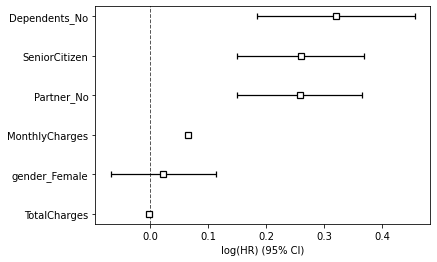

In [90]:
cph.plot() 

In [114]:
cph.params_

covariate
MonthlyCharges    0.006455
Partner_No        0.838239
Dependents_No     0.460406
gender_Female     0.014578
Name: coef, dtype: float64

<AxesSubplot:>

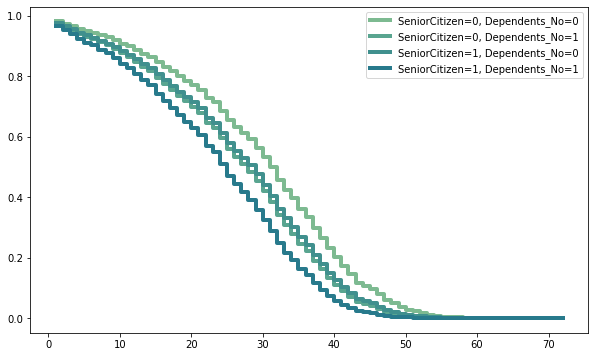

In [96]:
cph.plot_partial_effects_on_outcome(['SeniorCitizen','Dependents_No'], [
                                [0, 0],
                                [0, 1],
                                [1, 0],
                                [1, 1],
                            ], plot_baseline=False, figsize=(10, 6), lw=4) 

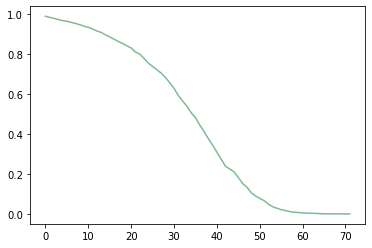

In [106]:
prediction = cph.predict_survival_function(df)
import matplotlib.pyplot as plt
plt.plot(prediction[0].values)

In [107]:
cph.predict_median(df)

0       36.0
1       47.0
2       17.0
3       57.0
4        8.0
        ... 
7038    34.0
7039     inf
7040    46.0
7041     8.0
7042     inf
Name: 0.5, Length: 7032, dtype: float64

In [108]:
cph.predict_partial_hazard(df)

0        3.231058
1        1.312994
2       16.955786
3        0.552120
4       47.871086
          ...    
7038     3.772007
7039     0.003076
7040     1.413677
7041    46.783687
7042     0.014016
Length: 7032, dtype: float64

### Survival Tree

Reference: https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

### C-Index

Reference: https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

### Aalen Additive Fitter

https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#aalen-s-additive-model

In [125]:
data.head(3)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   

      PaymentMethod MonthlyCharges TotalCharges  Churn entry_age  
0  Electronic check          29.85        29.85      0         0  
1      Mailed check          56.95       1889.5      0         0  
2      Mailed check          53.85       108.15      1         0  

[3 rows x 22 columns]

In [156]:
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(coef_penalizer=0.2, fit_intercept=False)
aaf.fit(data, 'tenure', event_col='Churn', formula='SeniorCitizen + Partner + Dependents + gender + MonthlyCharges + TotalCharges + TechSupport + StreamingTV + PaperlessBilling')



<lifelines.AalenAdditiveFitter: fitted with 7032 total observations, 5163 right-censored observations>

In [157]:
aaf.cumulative_hazards_.head()

covariate  Intercept  Dependents[T.Yes]  MonthlyCharges  \
1.0         0.102467          -0.000669        0.000647   
2.0         0.141142          -0.005975        0.001114   
3.0         0.167411          -0.010458        0.001457   
4.0         0.177960          -0.006114        0.002149   
5.0         0.181392          -0.011012        0.002713   

covariate  PaperlessBilling[T.Yes]  Partner[T.Yes]  SeniorCitizen  \
1.0                       0.015356       -0.026062       0.004741   
2.0                       0.015315       -0.034716       0.009561   
3.0                       0.020715       -0.036874       0.010396   
4.0                       0.021629       -0.040967       0.005067   
5.0                       0.022928       -0.040546       0.005812   

covariate  StreamingTV[T.No internet service]  StreamingTV[T.Yes]  \
1.0                                 -0.026481           -0.018658   
2.0                                 -0.039517           -0.026027   
3.0                                 -0.048229           -0.023208   
4.0                                 -0.053834           -0.031223   
5.0                                 -0.054917           -0.032025   

covariate  TechSupport[T.No internet service]  TechSupport[T.Yes]  \
1.0                                 -0.026481           -0.030859   
2.0                                 -0.039517           -0.039608   
3.0                                 -0.048229           -0.042107   
4.0                                 -0.053834           -0.046175   
5.0                                 -0.054917           -0.045102   

covariate  TotalCharges  gender[T.Male]  
1.0           -0.000027        0.001805  
2.0           -0.000039       -0.001842  
3.0           -0.000051       -0.003673  
4.0           -0.000064       -0.007188  
5.0           -0.000074       -0.006299

In [160]:
aaf.print_summary()

<lifelines.AalenAdditiveFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
           coef penalizer = 0.2
       number of subjects = 7032
number of events observed = 1869
         time fit was run = 2021-12-14 01:59:04 UTC

---
Empty DataFrame
Columns: []
Index: [Intercept, Dependents[T.Yes], MonthlyCharges, PaperlessBilling[T.Yes], Partner[T.Yes], SeniorCitizen, StreamingTV[T.No internet service], StreamingTV[T.Yes], TechSupport[T.No internet service], TechSupport[T.Yes], TotalCharges, gender[T.Male]]
---
Concordance = 0.51

<AxesSubplot:>

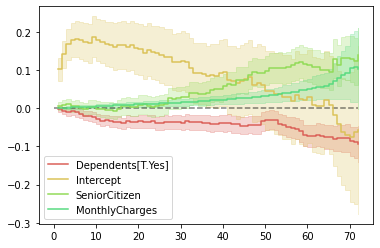

In [162]:
aaf.plot(columns=['Dependents[T.Yes]', 'Intercept', 'SeniorCitizen','MonthlyCharges'], iloc=slice(1,15))

In [174]:
print('median\n',aaf.predict_median(data).head(3))
print('percentile10\n',aaf.predict_percentile(data,0.1).head(3))
print('expectation\n',aaf.predict_expectation(data).head(3))
print('cumulative_hazard\n',aaf.predict_cumulative_hazard(data).head(3))
print('survival function\n',aaf.predict_survival_function(data).head(3))


median
 0    34.0
1    44.0
2    19.0
Name: 0.5, dtype: float64
percentile10
 0    67.0
1    68.0
2    56.0
Name: 0.1, dtype: float64
expectation
 0    32.168739
1    37.167909
2    22.836887
dtype: float64
cumulative_hazard
          0         1         2         3         4         5         6     \
1.0  0.110276  0.090811  0.151583  0.051773  0.159521  0.141785  0.106044   
2.0  0.153826  0.128208  0.210354  0.074199  0.229257  0.209098  0.144982   
3.0  0.193219  0.149960  0.257382  0.089002  0.283382  0.268106  0.180790   

         7         8         9     ...      7033      7034      7035  \
1.0  0.113674  0.028949  0.047072  ...  0.094699 -0.017557  0.112079   
2.0  0.162382  0.052701  0.058272  ...  0.128477 -0.026559  0.157294   
3.0  0.195301  0.082658  0.056478  ...  0.151284 -0.037718  0.199358   

         7036      7037      7038      7039      7040      7041      7042  
1.0  0.072396  0.040757  0.045247 -0.056815  0.101017  0.138272 -0.043753  
2.0  0.113763  0.044987 

### Reference:

https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html

https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html